In [132]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Tue Nov 26 18:33:54 2019

@author: greg
"""

import pandas as pd
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
#install from command line >  conda install -c bashtage arch then apply to the bigdata env virtual
from arch import arch_model
from statsmodels.tsa.holtwinters import SimpleExpSmoothing, Holt, ExponentialSmoothing
import pmdarima as pm
import statsmodels.api as sm


In [9]:

filename1 = "/home/greg/Desktop/Data Science/6823 Kilger Practicum/Exam2/cpapSummary2017_2019.csv"
cpapDF = pd.read_csv(filename1, header=0, parse_dates = ['Date'])
print(cpapDF[:5])#
#https://www.sleephealth.org/ufaqs/what-is-ahi-represent/  
#choose Date and AHI for the time series drop all else

        Date  Session Count                Start                  End  \
0 2017-09-01              1  2017-09-02T00:59:17  2017-09-02T08:00:17   
1 2017-09-02              2  2017-09-02T16:45:16  2017-09-03T07:24:31   
2 2017-09-03              1  2017-09-04T00:57:36  2017-09-04T07:06:37   
3 2017-09-04              1  2017-09-04T23:25:12  2017-09-05T09:12:13   
4 2017-09-05              1  2017-09-06T01:07:10  2017-09-06T06:54:11   

  Total Time    AHI  H Count  OA Count  UA Count  CA Count  ...  LF Count  \
0   07:01:00  0.998        4         2         0         1  ...         0   
1   08:23:03  5.725       20        26         0         2  ...         0   
2   06:09:01  3.414        7        13         0         1  ...         0   
3   09:47:01  3.986       12        25         0         2  ...         0   
4   05:47:01  6.916       15        22         0         3  ...         0   

   UF1 Count  UF2 Count  PP Count  Pressure  Avg  IPAP  Avg  EPAP  Avg  \
0          0          0 

In [10]:

cpapDF['AHI'] = pd.to_numeric(cpapDF['AHI'])
cpapDF = cpapDF.drop(['Session Count','Start','End','Total Time','OA Count','UA Count', 'CA Count', 'LF Count','UF1 Count', 'UF2 Count','PP Count','Pressure  Avg','IPAP  Avg','EPAP  Avg','Pressure 1%','IPAP 1%', 'EPAP 1%'], axis=1)
print("NA summaries",cpapDF.isna().sum().sum())
cpapDF = cpapDF.drop(['H Count','VS Count','VS2 Count','RE Count','FL Count','SA Count','NR Count','EP Count'], axis=1)
print(cpapDF[:5])
print(cpapDF.columns)
cpapDF['idx_date'] = cpapDF['Date']
cpapDF.set_index('idx_date',inplace=True)

NA summaries 0
        Date    AHI
0 2017-09-01  0.998
1 2017-09-02  5.725
2 2017-09-03  3.414
3 2017-09-04  3.986
4 2017-09-05  6.916
Index(['Date', 'AHI'], dtype='object')


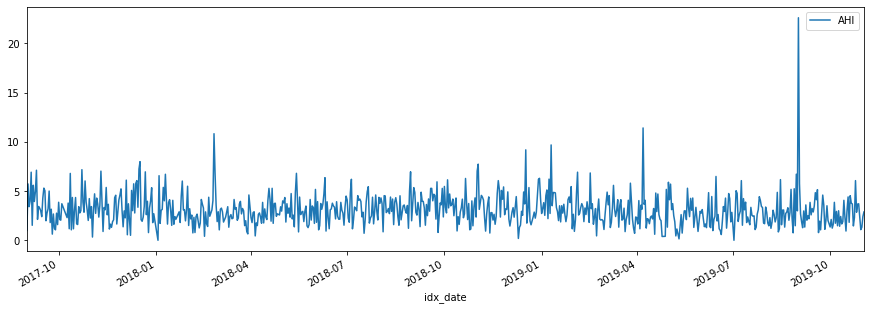

In [114]:

cpapDF = cpapDF.dropna() 
cpapDF1 = cpapDF.copy() #deep copy
cpapDF1 = cpapDF1.drop(['Date'], axis=1)
cpapDF1.plot(figsize=(15,5))
plt.show()


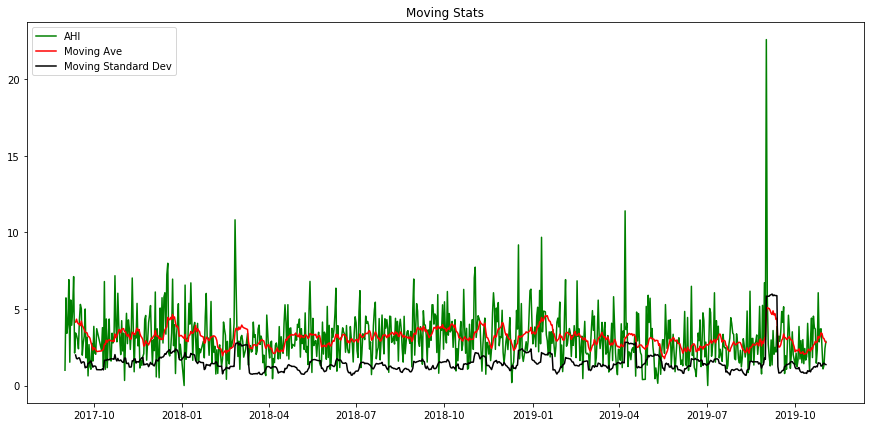

In [110]:
#calculate moving average by months of the year
moving_ave = cpapDF1.rolling(window = 12).mean()
#calculate moving standard deviation by months of the year
moving_dev = cpapDF1.rolling(window = 12).std()
plt.figure(figsize=(15,7))
plt.plot(cpapDF1, color = 'green', label = 'AHI')
plt.plot(moving_ave, color = 'red', label = 'Moving Ave')
plt.plot(moving_dev, color = 'black', label = 'Moving Standard Dev')
plt.legend(loc = 'best')
plt.title('Moving Stats')
plt.show()

In [6]:
#augmented Dickey Fuller from statsmodel library - take null hypoth that series is not stationary
ad_result = adfuller(cpapDF1['AHI'])
print(ad_result)
#too much, make it pretty
print('ADF stat = ', ad_result[0])
print('pVal = {0:.2f}'.format(ad_result[1]))  
print('crit values:')
for key, value in ad_result[4].items():
    print('\t{}: {}'.format(key, value))
#series is stationary p is significant so series is stationary
#ADF stat of -16 is much smaller than the 1% crit value so definitely stationary

(-16.842943386813953, 1.13432731133328e-29, 1, 773, {'1%': -3.438837902109151, '5%': -2.8652862410999114, '10%': -2.568764869203001}, 2901.971716337284)
ADF stat =  -16.842943386813953
pVal = 0.00
crit values:
	1%: -3.438837902109151
	5%: -2.8652862410999114
	10%: -2.568764869203001


In [7]:
#KPSS test - take null hypoth that series IS stationary
#have a hyper param here to check out:  lags
#reference:  https://faculty.washington.edu/ezivot/econ584/notes/unitrootLecture2.pdf
#indicates that lag too small remaining serial correlationin the errors will bias the test
#                   too large the test is no longer helpful determining stationariness
for lagT in [2,10,30,60,100]:
    kpss_result = kpss(cpapDF['AHI'], lags = lagT)
    print(kpss_result)
    
#and it is ugly.. make it pretty for lags=30 for 30 days=month 
kpss_result = kpss(cpapDF['AHI'], lags = 30)
print('KPSS stat = {}'.format(kpss_result[0]))
print('pVal = {0:.2f}'.format(kpss_result[1]))
print('crit vals:')
for key, value in kpss_result[3].items():
    print('\t{}: {}'.format(key, value))
# lag determines pVal and KPSS stat and this data is on the edge of acceptance of the null
# split decision... I will go with ADF since it is the typical standard it seems

(0.4846728780766449, 0.04511872115390882, 2, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(0.4396709851695841, 0.06005560984069652, 10, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(0.37302190527515605, 0.08878366151932929, 30, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(0.31755648843657935, 0.1, 60, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(0.2529867997591363, 0.1, 100, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS stat = 0.37302190527515605
pVal = 0.09
crit vals:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:541: FutureWarning: fft=True will become the default in a future version of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(msg, FutureWarning)


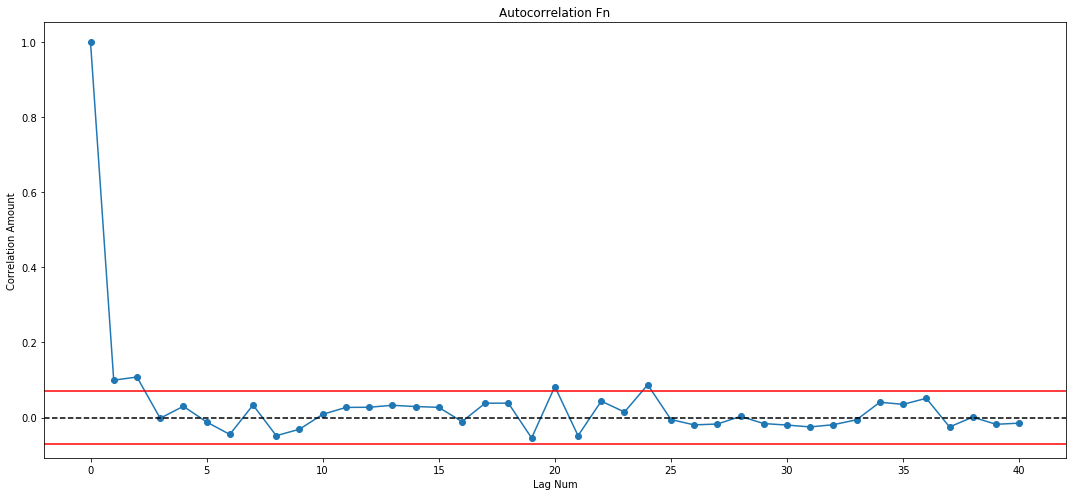

In [109]:
# determine ACF plot
lagACF=acf(cpapDF1)
plt.figure(figsize=(15,7))
plt.plot(lagACF, marker="o")
plt.axhline(y=0,linestyle='--',color='black')
plt.axhline(y=-1.96/np.sqrt(len(cpapDF1)),linestyle='-',color='red')
plt.axhline(y=1.96/np.sqrt(len(cpapDF1)),linestyle='-',color='red')
plt.title('Autocorrelation Fn')
plt.xlabel('Lag Num')
plt.ylabel('Correlation Amount')
plt.tight_layout()

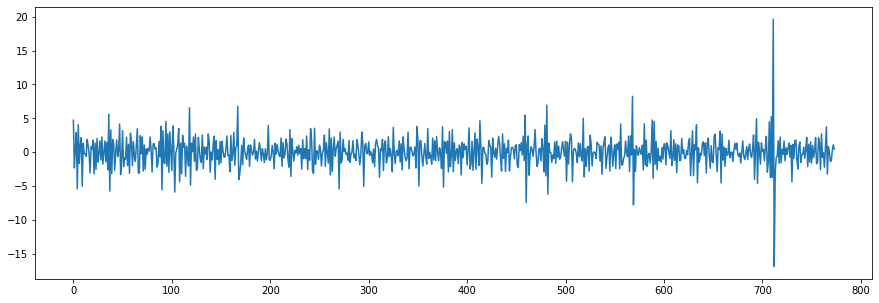

In [107]:
#Based on the Dickey Fuller and with some support from KPSS the cpap dataset is determined by me to be stationary
#  DIFFERENCED DATA  not needed but wanted to work it out partially
def difference(DF, interval=1):
    diff = list()
    for i in range(interval, len(DF)):
        value = DF[i] - DF[i - interval]
        diff.append(value)
    return diff

AHIseries = cpapDF1['AHI'].values
diff = difference(AHIseries)
plt.figure(figsize=(15,5))
plt.plot(diff)
plt.show()

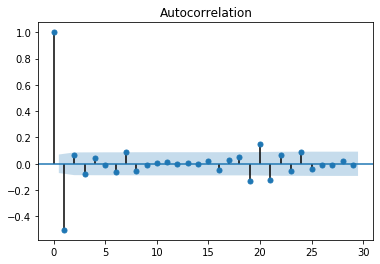

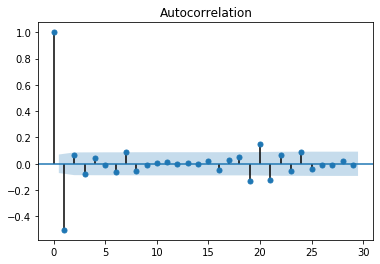

In [121]:
diffDF = pd.DataFrame(diff)
plot_acf(diffDF)

In [126]:
print(diffDF.describe())
for lagT in [2,10,30,60,100]:
    kpss_result = kpss(diffDF[0], lags = lagT)
    print(kpss_result)
    
#and it is ugly.. make it pretty for lags=30 for 30 days=month 
kpss_result = kpss(diffDF[0], lags = 30)
print('KPSS stat = {}'.format(kpss_result[0]))
print('pVal = {0:.2f}'.format(kpss_result[1]))
print('crit vals:')
for key, value in kpss_result[3].items():
    print('\t{}: {}'.format(key, value))

                0
count  774.000000
mean     0.002429
std      2.250821
min    -16.849000
25%     -1.272000
50%      0.079000
75%      1.308250
max     19.610000
(0.0031532995235760888, 0.1, 2, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(0.011674436353361996, 0.1, 10, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(0.03078452050868278, 0.1, 30, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(0.05873753411254202, 0.1, 60, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(0.09775008109214264, 0.1, 100, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS stat = 0.03078452050868278
pVal = 0.10
crit vals:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1710: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarni

In [105]:
# using Generalized Autoregressive Conditional Heteroskedasticity  (GARCH)
am = arch_model(cpapDF1)
# returns a model with a constant mean, GARCH(1,1) volatility process and normally distributed errors.
# specifying GARCH(0,1) produces ARCH model
res = am.fit(update_freq=5)
print(res.summary())


Iteration:      5,   Func. Count:     38,   Neg. LLF: 1493.5915549580295
Optimization terminated successfully.    (Exit mode 0)
            Current function value: 1493.5808611463622
            Iterations: 8
            Function evaluations: 56
            Gradient evaluations: 8
                     Constant Mean - GARCH Model Results                      
Dep. Variable:                    AHI   R-squared:                      -0.001
Mean Model:             Constant Mean   Adj. R-squared:                 -0.001
Vol Model:                      GARCH   Log-Likelihood:               -1493.58
Distribution:                  Normal   AIC:                           2995.16
Method:            Maximum Likelihood   BIC:                           3013.77
                                        No. Observations:                  775
Date:                Thu, Dec 12 2019   Df Residuals:                      771
Time:                        17:56:18   Df Model:                            4
       

<Figure size 1080x360 with 0 Axes>

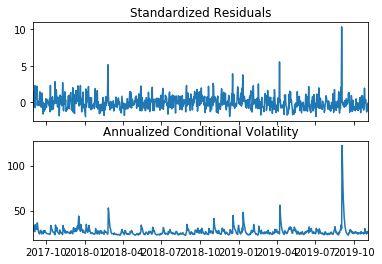

In [106]:
#visualize the GARCH results
# the annualize parm can have values ‘D’ (daily), ‘W’ (weekly)and ‘M’ (monthly)
# these values scale variance by 252, 52, and 12:  since the cpap data measurements are by day, using 'D'
fig = res.plot(annualize='D')

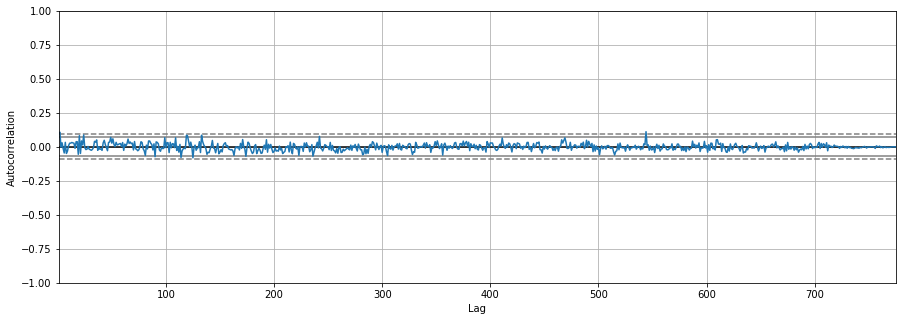

In [103]:
plt.figure(figsize=(15,5))
autocorrelation_plot(cpapDF1)
plt.show()

/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.AHI   No. Observations:                  774
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -1612.318
Method:                       css-mle   S.D. of innovations              1.942
Date:                Sun, 08 Dec 2019   AIC                           3230.636
Time:                        23:40:17   BIC                           3244.591
Sample:                             1   HQIC                          3236.005
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0002      0.046      0.004      0.997      -0.091       0.091
ar.L1.D.AHI    -0.5050      0.031    -16.241      0.000      -0.566      -0.444
                                    Roots       

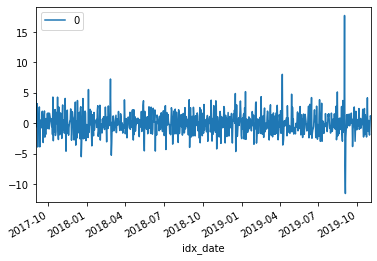

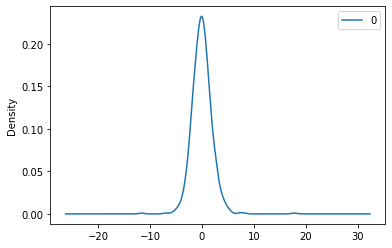

                0
count  774.000000
mean     0.003084
std      1.945637
min    -11.577515
25%     -1.150205
50%     -0.030510
75%      1.066527
max     17.729001


In [20]:
# fit model
model = ARIMA(cpapDF1, order=(1,1,0))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.AHI   No. Observations:                  774
Model:                 ARIMA(3, 1, 1)   Log Likelihood               -1492.223
Method:                       css-mle   S.D. of innovations              1.657
Date:                Thu, 12 Dec 2019   AIC                           2996.447
Time:                        17:55:37   BIC                           3024.356
Sample:                             1   HQIC                          3007.185
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0006      0.000     -1.774      0.077      -0.001    5.92e-05
ar.L1.D.AHI     0.0888      0.036      2.468      0.014       0.018       0.159
ar.L2.D.AHI     0.0986      0.036      2.740    

<Figure size 1080x360 with 0 Axes>

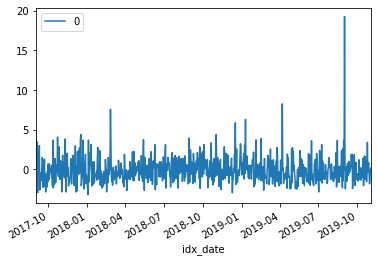

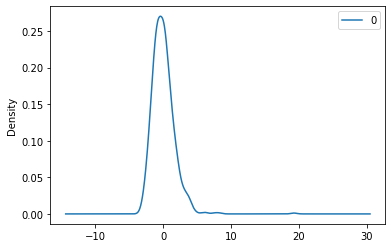

                0
count  774.000000
mean     0.001344
std      1.667982
min     -3.171201
25%     -1.079064
50%     -0.149548
75%      0.819183
max     19.274433


In [102]:
model = ARIMA(cpapDF1, order=(3,1,1))
model_fit = model.fit(disp=0)
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
plt.figure(figsize=(15,5))
residuals.plot()
plt.show()
residuals.plot(kind='kde')
plt.show()
print(residuals.describe())

In [12]:
#forecast using pdq 1,0,0
model = ARIMA(cpapDF1, order=(1,0,0))
model_fit = model.fit(disp=0)
fc, se, conf = model_fit.forecast(15, alpha=0.05)  # 95% conf
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                    AHI   No. Observations:                  775
Model:                     ARMA(1, 0)   Log Likelihood               -1496.068
Method:                       css-mle   S.D. of innovations              1.668
Date:                Wed, 11 Dec 2019   AIC                           2998.136
Time:                        23:20:17   BIC                           3012.095
Sample:                             0   HQIC                          3003.506
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1011      0.067     46.612      0.000       2.971       3.231
ar.L1.AHI      0.0997      0.036      2.788      0.005       0.030       0.170
                                    Roots           

/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


In [17]:
#forecast using pdq 1,0,1
model = ARIMA(cpapDF1, order=(1,0,1))
model_fit = model.fit(disp=0)
fc, se, conf = model_fit.forecast(15, alpha=0.05)  # 95% conf
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                    AHI   No. Observations:                  775
Model:                     ARMA(1, 1)   Log Likelihood               -1493.814
Method:                       css-mle   S.D. of innovations              1.663
Date:                Wed, 11 Dec 2019   AIC                           2995.628
Time:                        23:30:06   BIC                           3014.239
Sample:                             0   HQIC                          3002.788
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1009      0.074     42.008      0.000       2.956       3.246
ar.L1.AHI      0.5573      0.160      3.489      0.001       0.244       0.870
ma.L1.AHI     -0.4526      0.170     -2.659      0.0

/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


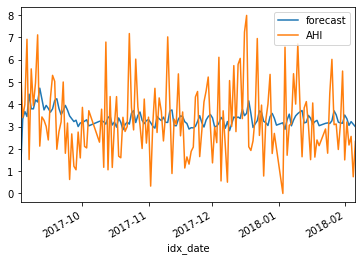

In [117]:
# doing the cool forecast plot with the best arima model pdq 1,0,1
model_fit.plot_predict(1, 150, dynamic=False)
plt.show()
#not so great but the P values were pretty high and my trend is down slightly over the period for bad apnea counts

In [15]:
#forecast using pdq 1,1,1
model = ARIMA(cpapDF1, order=(1,1,1))
model_fit = model.fit(disp=0)
fc, se, conf = model_fit.forecast(15, alpha=0.05)  # 95% conf
print(model_fit.summary())

/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.AHI   No. Observations:                  774
Model:                 ARIMA(1, 1, 1)   Log Likelihood               -1495.902
Method:                       css-mle   S.D. of innovations              1.668
Date:                Wed, 11 Dec 2019   AIC                           2999.804
Time:                        23:25:58   BIC                           3018.410
Sample:                             1   HQIC                          3006.963
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0007      0.001     -0.853      0.394      -0.002       0.001
ar.L1.D.AHI     0.0881      0.037      2.386      0.017       0.016       0.160
ma.L1.D.AHI    -0.9899      0.009   -107.589    

In [14]:
#forecast using pdq 2,1,1
model = ARIMA(cpapDF1, order=(2,1,1))
model_fit = model.fit(disp=0)
fc, se, conf = model_fit.forecast(15, alpha=0.05)
print(model_fit.summary())

/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                             ARIMA Model Results                              
Dep. Variable:                  D.AHI   No. Observations:                  774
Model:                 ARIMA(2, 1, 1)   Log Likelihood               -1492.454
Method:                       css-mle   S.D. of innovations              1.657
Date:                Wed, 11 Dec 2019   AIC                           2994.909
Time:                        23:22:30   BIC                           3018.167
Sample:                             1   HQIC                          3003.857
                                                                              
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const          -0.0006      0.000     -1.733      0.083      -0.001    7.37e-05
ar.L1.D.AHI     0.0865      0.036      2.414      0.016       0.016       0.157
ar.L2.D.AHI     0.0965      0.036      2.690    

In [127]:
#forecast using best pdq 1.0,1
model = ARIMA(cpapDF1, order=(1,0,1))
model_fit = model.fit(disp=0)
fc, se, conf = model_fit.forecast(15, alpha=0.05)
print(model_fit.summary())

                              ARMA Model Results                              
Dep. Variable:                    AHI   No. Observations:                  775
Model:                     ARMA(1, 1)   Log Likelihood               -1493.814
Method:                       css-mle   S.D. of innovations              1.663
Date:                Thu, 12 Dec 2019   AIC                           2995.628
Time:                        18:39:23   BIC                           3014.239
Sample:                             0   HQIC                          3002.788
                                                                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          3.1009      0.074     42.008      0.000       2.956       3.246
ar.L1.AHI      0.5573      0.160      3.489      0.001       0.244       0.870
ma.L1.AHI     -0.4526      0.170     -2.659      0.0

/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


Seasonal analysis

In [62]:
# data from:  http://tonto.eia.gov/dnav/pet/hist/LeafHandler.ashx?n=PET&s=MCRFPUS1&f=M
filename2 = "/home/greg/Desktop/Data Science/6823 Kilger Practicum/Exam2/oilData/MCRFPUS1m.xls"
oilDF = pd.read_excel(filename2, header=0, index_col='Date')
oilDF['k_Barrels'] = oilDF['k_Barrels'].replace(r"[a-zA-Z]",'')

            k_Barrels
Date                 
1920-01-15      34008
1920-02-15      33193
1920-03-15      36171
1920-04-15      34945
1920-05-15      36622


In [72]:

oil1 = oilDF['k_Barrels']
oil1.head()

Date
1920-01-15    34008
1920-02-15    33193
1920-03-15    36171
1920-04-15    34945
1920-05-15    36622
Name: k_Barrels, dtype: int64

Date
1960-01-15    224140
1960-02-15    209986
1960-03-15    220977
1960-04-15    211132
1960-05-15    212296
               ...  
2007-08-15    154060
2007-09-15    147061
2007-10-15    155680
2007-11-15    151021
2007-12-15    158427
Name: k_Barrels, Length: 576, dtype: int64


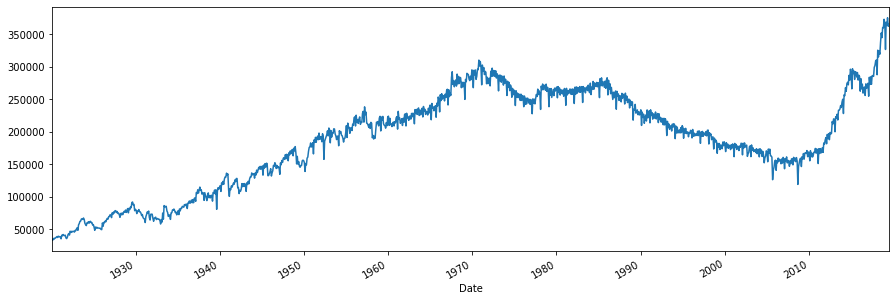

In [83]:

oil1.plot(kind="line",figsize=(15,5))
#after looking at the plot it seems that 1960 to 2007 seem to have the best consistency with a consistent extraction technology
#fracking starts in 2008
#prior to 1960 a variety of companies used a wide variety of extraction techniques and the industry hadn't consolidated
split_date = pd.datetime(1960,1,15)
drop = oil1.loc[oil1.index < split_date]
keep = oil1.loc[oil1.index >= split_date]
split_date = pd.datetime(2008,1,15)
finalkeep = keep.loc[keep.index < split_date]

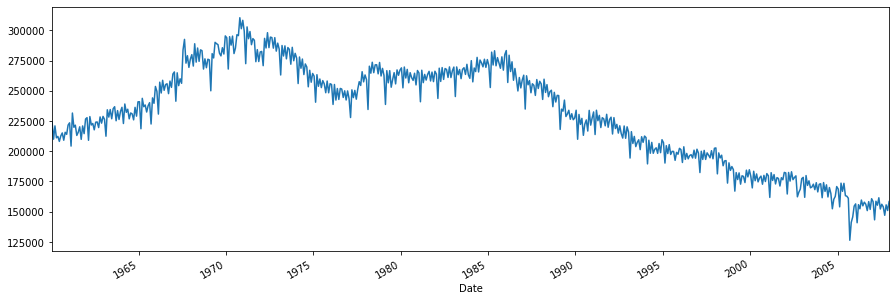

In [84]:
finalkeep.plot(kind="line",figsize=(15,5))

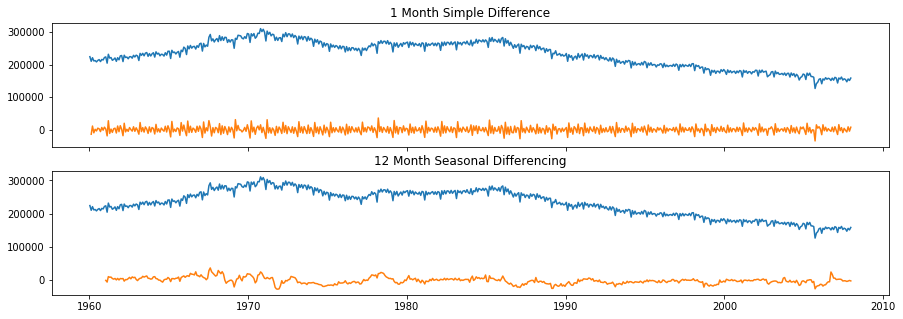

In [90]:
fig, axes = plt.subplots(2, 1, figsize=(15,5), dpi=72, sharex=True)
#simple difference
axes[0].plot(finalkeep[:], label='Historical US Oil Production')
axes[0].plot(finalkeep[:].diff(1))  # 1 month diff
axes[0].set_title('1 Month Simple Difference')

#seasonal
axes[1].plot(finalkeep[:], label='Historical US Oil Production')
axes[1].plot(finalkeep[:].diff(12)) #12 month diff
axes[1].set_title('12 Month Seasonal Differencing')
plt.show()

In [131]:
print(finalkeep.describe())
for lagT in [1,2,3,6,12]:
    kpss_result = kpss(finalkeep, lags = lagT)
    print(kpss_result)
    
#and it is ugly.. make it pretty for lags=30 for 30 days=month 
kpss_result = kpss(finalkeep, lags = 12)
print('KPSS stat = {}'.format(kpss_result[0]))
print('pVal = {0:.2f}'.format(kpss_result[1]))
print('crit vals:')
for key, value in kpss_result[3].items():
    print('\t{}: {}'.format(key, value))

count       576.000000
mean     231123.135417
std       40665.612041
min      126417.000000
25%      198678.000000
50%      235724.000000
75%      264966.500000
max      310403.000000
Name: k_Barrels, dtype: float64
(18.55483475939312, 0.01, 1, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(12.43374315070033, 0.01, 2, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(9.356580823676374, 0.01, 3, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(5.386736095191067, 0.01, 6, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
(2.934833497774455, 0.01, 12, {'10%': 0.347, '5%': 0.463, '2.5%': 0.574, '1%': 0.739})
KPSS stat = 2.934833497774455
pVal = 0.01
crit vals:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/stattools.py:1708: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarni

In [86]:
smodel = pm.auto_arima(finalkeep, start_p=1, start_q=1,
                         test='adf',
                         max_p=3, max_q=3, m=12,
                         start_P=0, seasonal=True,
                         d=None, D=1, trace=True,
                         error_action='ignore',  
                         suppress_warnings=True, 
                         stepwise=True)

smodel.summary()

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=11880.755, BIC=11902.430, Fit time=1.847 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=11956.180, BIC=11964.850, Fit time=0.054 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=11861.492, BIC=11878.832, Fit time=1.307 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=11744.519, BIC=11761.859, Fit time=1.045 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=11747.013, BIC=11768.688, Fit time=1.151 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=11743.119, BIC=11756.124, Fit time=0.208 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=11699.029, BIC=11716.370, Fit time=0.994 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=11913.116, BIC=11926.121, Fit time=0.173 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 1, 0, 12); AIC=11924.308, BIC=11945.983, Fit time=0.995 seconds
Fit ARIMA:

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                 
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  576
Model:             SARIMAX(2, 0, 1)x(1, 1, 0, 12)   Log Likelihood               -5808.399
Date:                            Thu, 12 Dec 2019   AIC                          11628.798
Time:                                    01:34:33   BIC                          11654.808
Sample:                                         0   HQIC                         11638.951
                                            - 576                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   -197.7977     55.212     -3.582      0.000    -306.012     -89.583
ar.L1          1.3287      0.030     44.617      0.000       1.270       1.387
ar.L2         -0.3737      0.024    -15.765      0.000      -0.420      -0.327
ma.L1         -0.8669      0.018    -46.957      0.000      -0.903      -0.831
ar.S.L12      -0.2855      0.008    -35.587      0.000      -0.301      -0.270
sigma2      5.148e+07      0.000   1.15e+11      0.000    5.15e+07    5.15e+07
===================================================================================
Ljung-Box (Q):                      272.09   Jarque-Bera (JB):             26469.44
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               0.19   Skew:                            -2.76
Prob(H) (two-sided):                  0.00   Kurtosis:                        36.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 5.5e+25. Standard errors may be unstable.
"""

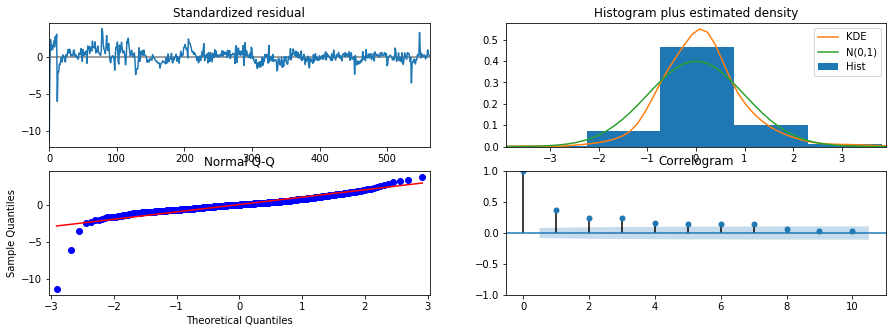

In [91]:
smodel.plot_diagnostics(figsize=(15,5))
plt.show()

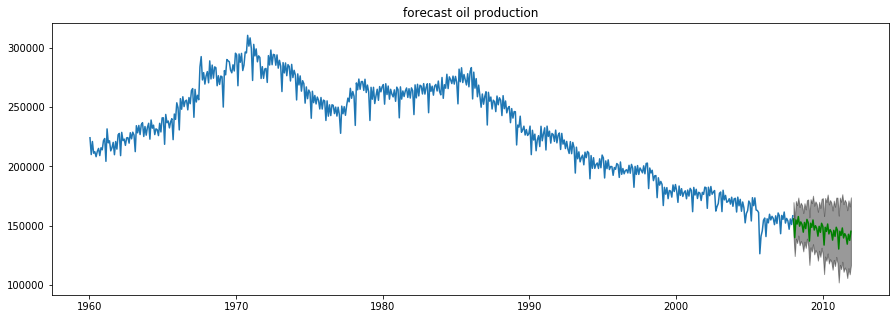

In [95]:
n_periods = 48
fitted, confint = smodel.predict(n_periods=n_periods, return_conf_int=True)
index_of_fc = pd.date_range(finalkeep.index[-1], periods = n_periods, freq='MS')
fitseries = pd.Series(fitted, index=index_of_fc)
loseries = pd.Series(confint[:, 0], index=index_of_fc)
upseries = pd.Series(confint[:, 1], index=index_of_fc)
plt.figure(figsize=(15,5))
plt.plot(finalkeep)
plt.plot(fitseries, color='green')
plt.fill_between(loseries.index, 
                 loseries, 
                 upseries, 
                 color='k', alpha=.4)
plt.title("forecast oil production")
plt.show()
#The result is not too bad but the error explodes as the forecast continues and it underestimates the growth

In [99]:
import statsmodels.api as sm
sm.tsa.seasonal_decompose(oilDF['k_Barrels']).plot()
result = sm.tsa.stattools.adfuller(oilDF['k_Barrels'])
plt.show()

ValueError: You must specify a freq or x must be a pandas object with a timeseries index with a freq not set to None

In [100]:
#oilDF.index.freq = '12M'
train, test = oilDF.iloc[:48, 0], oilDF.iloc[48:, 0]
model = ExponentialSmoothing(train, seasonal='mul', seasonal_periods=12).fit()
#pred = model.predict(start=test.index[0], end=test.index[-1])
pred = model.predict(start='2015-07-15', end='2019-07-15')

plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Test')
plt.plot(pred.index, pred, label='Holt-Winters')
plt.legend(loc='best')

/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


KeyError: 'The `start` argument could not be matched to a location related to the index of the data.'

In [71]:
fit1 = SimpleExpSmoothing(dataSeries).fit(smoothing_level=0.2,optimized=True)
forecast1 = fit1.forecast(48).rename(r'$\alpha=0.2$')
forecast1.plot(marker='o', color='blue', legend=True)
fit1.fittedvalues.plot(marker='o',  color='black')
#next fit overlay on plot
fit2 = SimpleExpSmoothing(dataSeries).fit(smoothing_level=0.6,optimized=True)
forecast2 = fit2.forecast(48).rename(r'$\alpha=0.6$')
forecast2.plot(marker='o', color='red', legend=True)
fit2.fittedvalues.plot(marker='o', color='orange')
#final fit overlay on plot
fit3 = SimpleExpSmoothing(dataSeries).fit()
forecast3 = fit3.forecast(48).rename(r'$\alpha=%s$'%fit3.model.params['smoothing_level'])
forecast3.plot(marker='o', color='green', legend=True)
#fit3.fittedvalues.plot(marker='o', color='green')
plt.show()

/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:576: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


ValueError: year 0 is out of range

Error in callback <function install_repl_displayhook.<locals>.post_execute at 0x7f321ad4a400> (for post_execute):


ValueError: year 0 is out of range

ValueError: year 0 is out of range

In [134]:
unrestricted_model = {
    'level': 'local linear trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
}

restricted_model = {
    'level': 'smooth trend', 'cycle': True, 'damped_cycle': True, 'stochastic_cycle': True
}

output_mod = sm.tsa.UnobservedComponents(finalkeep, **unrestricted_model)
output_res = output_mod.fit(method='powell', disp=False)
print(output_res.summary())


/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:219: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


                            Unobserved Components Results                            
Dep. Variable:                     k_Barrels   No. Observations:                  576
Model:                    local linear trend   Log Likelihood               -5994.184
                   + damped stochastic cycle   AIC                          12000.368
Date:                       Thu, 12 Dec 2019   BIC                          12026.463
Time:                               19:30:31   HQIC                         12010.548
Sample:                                    0                                         
                                       - 576                                         
Covariance Type:                         opg                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
sigma2.irregular  1.824e-11   1.99e+05   9.16e-17      1

/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/base/model.py:1294: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse
/home/greg/anaconda3/envs/BigDataPy36_env/lib/python3.6/site-packages/statsmodels/tsa/statespace/mlemodel.py:2059: RuntimeWarning: divide by zero encountered in true_divide
  return self.params / self.bse


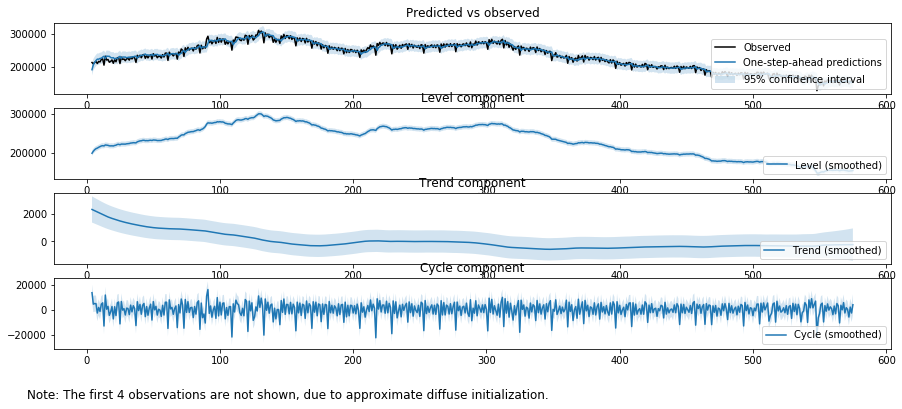

In [135]:
fig = output_res.plot_components(legend_loc='lower right', figsize=(15, 6));